#### Constructing a Low-Correlation Portfolio with Positive-Return Stocks

In [1]:
import pandas as pd
import numpy as np

# Step 1: Load Data
data_file = "ASX_Historical_Prices_2023-06-07_to_2024-06-06.csv"
historical_data = pd.read_csv(data_file)

if "Close" not in historical_data.columns or "Ticker" not in historical_data.columns:
    raise ValueError("The data file lacks necessary columns 'Close' and 'Ticker'.")

# Step 2: Align with Standard Trading Days
start_date = "2023-06-07"
end_date = "2024-06-06"
trading_days = pd.date_range(start=start_date, end=end_date, freq="B")
tickers = historical_data["Ticker"].unique()

aligned_data = []
for ticker in tickers:
    stock_data = historical_data[historical_data["Ticker"] == ticker]
    stock_data = stock_data.set_index(pd.RangeIndex(len(stock_data)))  # Reset index
    stock_data["Date"] = trading_days[: len(stock_data)]  # Assign trading days
    stock_data = stock_data.set_index("Date").reindex(trading_days)  # Reindex to all trading days
    stock_data["Ticker"] = ticker
    stock_data = stock_data.fillna(method="ffill")  # Fill missing data forward
    aligned_data.append(stock_data)

aligned_historical_data = pd.concat(aligned_data)
aligned_historical_data.reset_index(inplace=True)
aligned_historical_data.rename(columns={"index": "Date"}, inplace=True)

# Step 3: Calculate Daily Returns
aligned_historical_data["Daily_Return"] = aligned_historical_data.groupby("Ticker")["Close"].pct_change()

# Step 4: Filter for Stocks with Positive Returns
mean_returns = aligned_historical_data.groupby("Ticker")["Daily_Return"].mean()
positive_return_tickers = mean_returns[mean_returns > 0].index
filtered_data = aligned_historical_data[aligned_historical_data["Ticker"].isin(positive_return_tickers)]
print(f"Filtered stocks with positive returns: {len(positive_return_tickers)}")
print(f"Tickers with positive returns: {positive_return_tickers.tolist()}")

# Step 5: Calculate Correlation Matrix and Volatility
pivot_table = filtered_data.pivot(index="Date", columns="Ticker", values="Daily_Return")
correlation_matrix = pivot_table.corr()
volatility = filtered_data.groupby("Ticker")["Daily_Return"].std()

# Save outputs
correlation_matrix.to_csv("ASX_Correlation_Matrix_Positive_Return_1126.csv")
volatility.to_csv("ASX_Stock_Volatility_Positive_Return_1126.csv")
print("Correlation matrix saved to ASX_Correlation_Matrix_Positive_Return_1126.csv")
print("Volatility saved to ASX_Stock_Volatility_Positive_Return_1126.csv")

# Step 6: Identify Low-Correlation Pairs
threshold = 0.3
low_corr_pairs = [
    (s1, s2, correlation_matrix.loc[s1, s2], (volatility[s1] + volatility[s2]) / 2)
    for s1 in correlation_matrix.columns
    for s2 in correlation_matrix.columns
    if s1 != s2 and correlation_matrix.loc[s1, s2] < threshold
]
low_corr_df = pd.DataFrame(low_corr_pairs, columns=["Stock1", "Stock2", "Correlation", "Avg_Volatility"])
low_corr_df = low_corr_df.sort_values(by=["Correlation", "Avg_Volatility"], ascending=[True, True])

# Save low-correlation pairs
low_corr_file = "ASX_Low_Correlation_Low_Volatility_Pairs_Positive_Return_1126.csv"
low_corr_df.to_csv(low_corr_file, index=False)
print(f"Low-correlation pairs saved to {low_corr_file}")

# Step 7: Build Portfolio Using Risk-Return Ratio
selected_stocks = set()
for _, row in low_corr_df.iterrows():
    if len(selected_stocks) >= 40:  # Add a buffer for high-quality candidates
        break
    selected_stocks.add(row["Stock1"])
    selected_stocks.add(row["Stock2"])

# Calculate Risk-Return Ratio
risk_return_ratio = {ticker: mean_returns[ticker] / volatility[ticker] for ticker in selected_stocks}
selected_stocks_sorted = sorted(
    risk_return_ratio,
    key=risk_return_ratio.get,
    reverse=True  # High risk-return ratio first
)

# Select Final 20 Stocks
final_portfolio = selected_stocks_sorted[:20]

# Save Final Portfolio
portfolio_file = "ASX_Selected_Portfolio_Positive_Return_1126.csv"
portfolio_excel_file = "ASX_Selected_Portfolio_Positive_Return_1126.xlsx"
pd.DataFrame(final_portfolio, columns=["Stock_Code"]).to_csv(portfolio_file, index=False)
pd.DataFrame(final_portfolio, columns=["Stock_Code"]).to_excel(portfolio_excel_file, index=False)

print(f"Final portfolio saved to {portfolio_file}")
print(f"Final portfolio saved to {portfolio_excel_file}")

# Step 8: Validate Portfolio Correlation
def calculate_avg_correlation(selected_stocks, correlation_matrix):
    correlations = [
        correlation_matrix.loc[s1, s2]
        for i, s1 in enumerate(selected_stocks)
        for s2 in selected_stocks[i + 1 :]
    ]
    return np.mean(correlations)

avg_correlation = calculate_avg_correlation(final_portfolio, correlation_matrix)
if avg_correlation > 0.3:
    print(f"Average portfolio correlation is {avg_correlation:.2f}, adjustment may be needed.")
else:
    print(f"Average portfolio correlation is {avg_correlation:.2f}, portfolio is acceptable.")


/var/folders/kq/1c1dzqtj4b7_9p_ygqzc4nfw0000gn/T/ipykernel_27406/3956002203.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method="ffill")  # Fill missing data forward
/var/folders/kq/1c1dzqtj4b7_9p_ygqzc4nfw0000gn/T/ipykernel_27406/3956002203.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method="ffill")  # Fill missing data forward
/var/folders/kq/1c1dzqtj4b7_9p_ygqzc4nfw0000gn/T/ipykernel_27406/3956002203.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method="ffill")  # Fill missing data forward
/var/folders/kq/1c1dzqtj4b7_9p_ygqzc4nfw0000gn/T/ipykernel_27406/3956002203.py:24: FutureWarning: DataFrame.f

Filtered stocks with positive returns: 1152
Tickers with positive returns: ['14D.AX', '1AD.AX', '1AE.AX', '1AI.AX', '1CG.AX', '1TT.AX', '29M.AX', '360.AX', '3DA.AX', '3PL.AX', '4DS.AX', '4DX.AX', '5GN.AX', '88E.AX', 'A1M.AX', 'A2M.AX', 'A3D.AX', 'A8G.AX', 'AAC.AX', 'AAM.AX', 'AAP.AX', 'AAR.AX', 'ABB.AX', 'ABV.AX', 'ABY.AX', 'ACE.AX', 'ACF.AX', 'ACP.AX', 'ACR.AX', 'ACU.AX', 'AD1.AX', 'AD8.AX', 'ADA.AX', 'ADG.AX', 'ADH.AX', 'ADR.AX', 'ADS.AX', 'ADT.AX', 'ADX.AX', 'ADY.AX', 'AEE.AX', 'AEF.AX', 'AEI.AX', 'AEV.AX', 'AFI.AX', 'AFL.AX', 'AGC.AX', 'AGD.AX', 'AGE.AX', 'AGI.AX', 'AGL.AX', 'AGN.AX', 'AGR.AX', 'AHC.AX', 'AHF.AX', 'AHI.AX', 'AHK.AX', 'AHN.AX', 'AI1.AX', 'AII.AX', 'AIM.AX', 'AIQ.AX', 'AJL.AX', 'AJX.AX', 'AKM.AX', 'AKO.AX', 'AL3.AX', 'ALA.AX', 'ALD.AX', 'ALL.AX', 'ALM.AX', 'ALQ.AX', 'ALR.AX', 'AMC.AX', 'AMD.AX', 'AMH.AX', 'AMI.AX', 'AML.AX', 'AMN.AX', 'AMO.AX', 'AMP.AX', 'AMX.AX', 'ANG.AX', 'ANR.AX', 'ANZ.AX', 'AO1.AX', 'AOA.AX', 'AOF.AX', 'AON.AX', 'APS.AX', 'APW.AX', 'APZ.AX', 'AQD

#### Generating Portfolio Mean Returns and Covariance Matrix with Positive-Return Stocks

In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Step 1: Load data
data_file = "ASX_Historical_Prices_2023-06-07_to_2024-06-06.csv"
historical_data = pd.read_csv(data_file)

if "Close" not in historical_data.columns or "Ticker" not in historical_data.columns:
    raise ValueError("The dataset is missing required columns, please check the file.")

# Step 2: Align trading dates
tickers = historical_data["Ticker"].unique()
aligned_data = []

for ticker in tickers:
    stock_data = historical_data[historical_data["Ticker"] == ticker]
    stock_data = stock_data.ffill()  # Fill missing values forward
    aligned_data.append(stock_data)

aligned_historical_data = pd.concat(aligned_data)

# Step 3: Calculate daily returns
aligned_historical_data["Daily_Return"] = (
    aligned_historical_data.groupby("Ticker")["Close"].pct_change()
)

# Step 4: Filter portfolio data
portfolio_stocks = pd.read_csv("ASX_Selected_Portfolio_Positive_Return_1126.csv")["Stock_Code"].tolist()
portfolio_data = aligned_historical_data[aligned_historical_data["Ticker"].isin(portfolio_stocks)]

# Calculate mean returns
mean_returns = portfolio_data.groupby("Ticker")["Daily_Return"].mean()

# Prepare pivot table
pivot_table = portfolio_data.pivot(columns="Ticker", values="Daily_Return")

# Filter assets with sufficient data
valid_tickers = pivot_table.columns[pivot_table.notna().sum() > 10]
pivot_table = pivot_table[valid_tickers]

# Fill missing values
pivot_table = pivot_table.apply(lambda x: x.fillna(x.mean()), axis=0)

# Normalize data
scaler = StandardScaler()
normalized_returns = scaler.fit_transform(pivot_table)

# Calculate covariance matrix
normalized_cov_matrix = pd.DataFrame(
    np.cov(normalized_returns.T, bias=True), 
    index=pivot_table.columns, 
    columns=pivot_table.columns
)

# Step 5: Save results
mean_returns_file = "Portfolio_Mean_Returns__Positive_Return_1126.csv"
cov_matrix_file = "Portfolio_Covariance_Matrix__Positive_Return_1126.csv"

mean_returns.to_csv(mean_returns_file)
normalized_cov_matrix.to_csv(cov_matrix_file)

print(f"Mean returns saved to {mean_returns_file}")
print(f"Normalized covariance matrix saved to {cov_matrix_file}")

# Step 6: Print summary
print("\nSample Mean Returns:")
print(mean_returns.head())

print("\nSample Normalized Covariance Matrix:")
print(normalized_cov_matrix.iloc[:5, :5])


Mean returns saved to Portfolio_Mean_Returns__Positive_Return_1126.csv
Normalized covariance matrix saved to Portfolio_Covariance_Matrix__Positive_Return_1126.csv

Sample Mean Returns:
Ticker
4DS.AX    0.007521
ACP.AX    0.004056
ATU.AX    0.000004
AZ9.AX    0.000646
BB1.AX    0.004792
Name: Daily_Return, dtype: float64

Sample Normalized Covariance Matrix:
Ticker        4DS.AX        ACP.AX        ATU.AX        AZ9.AX        BB1.AX
Ticker                                                                      
4DS.AX  1.000000e+00  2.192500e-35  5.323045e-35  2.059136e-35  9.627909e-36
ACP.AX  2.192500e-35  1.000000e+00 -9.412871e-35 -1.164079e-34 -3.386646e-36
ATU.AX  5.323045e-35 -9.412871e-35  1.000000e+00 -1.026252e-34 -6.239764e-35
AZ9.AX  2.059136e-35 -1.164079e-34 -1.026252e-34  1.000000e+00  7.317835e-35
BB1.AX  9.627909e-36 -3.386646e-36 -6.239764e-35  7.317835e-35  1.000000e+00


In [76]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# 加载数据
mean_returns = pd.read_csv("Portfolio_Mean_Returns__Positive_Return_1126.csv", index_col=0).squeeze()
cov_matrix = pd.read_csv("Portfolio_Covariance_Matrix__Positive_Return_1126.csv", index_col=0)
risk_free_rate = 0.0452

# 权重约束
num_assets = len(mean_returns)
bounds = tuple((0, 0.3) for _ in range(num_assets))  # 单一资产最大权重限制为 30%
constraints = {"type": "eq", "fun": lambda weights: np.sum(weights) - 1}

# 定义目标函数
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

# 优化最大夏普比率
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]

opt_sharpe = minimize(
    negative_sharpe_ratio,
    np.ones(num_assets) / num_assets,
    args=(mean_returns, cov_matrix, risk_free_rate),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)

# 优化最小波动率
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

opt_volatility = minimize(
    portfolio_volatility,
    np.ones(num_assets) / num_assets,
    args=(cov_matrix,),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)

# 结果提取
max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio = portfolio_performance(
    opt_sharpe.x, mean_returns, cov_matrix, risk_free_rate
)
min_volatility_return, min_volatility_volatility, _ = portfolio_performance(
    opt_volatility.x, mean_returns, cov_matrix, risk_free_rate
)

# 输出结果
print("Max Sharpe Ratio Portfolio:")
print(f"Weights: {opt_sharpe.x}")
print(f"Return: {max_sharpe_return*100:.2f}%, Volatility: {max_sharpe_volatility*100:.2f}%, Sharpe Ratio: {max_sharpe_ratio:.2f}")

print("\nMin Volatility Portfolio:")
print(f"Weights: {opt_volatility.x}")
print(f"Return: {min_volatility_return*100:.2f}%, Volatility: {min_volatility_volatility*100:.2f}%")


Max Sharpe Ratio Portfolio:
Weights: [1.00000000e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.40186082e-17 3.00000000e-01 1.56125113e-17 5.42101086e-18
 0.00000000e+00 3.00000000e-01 1.62630326e-18 0.00000000e+00
 0.00000000e+00 2.81892565e-18 3.00000000e-01 1.59377719e-17
 0.00000000e+00]
Return: 1.75%, Volatility: 52.92%, Sharpe Ratio: -0.05

Min Volatility Portfolio:
Weights: [0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353]
Return: 0.62%, Volatility: 24.25%


有效资产数量: 20

最大夏普比率组合:
权重: [0.00000000e+00 0.00000000e+00 5.12110868e-17 6.84751433e-17
 0.00000000e+00 0.00000000e+00 4.65396862e-18 5.78228283e-16
 1.59278895e-17 0.00000000e+00 0.00000000e+00 7.97185550e-18
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 1.89827457e-18]
回报率: 2.32%
波动率: 100.00%


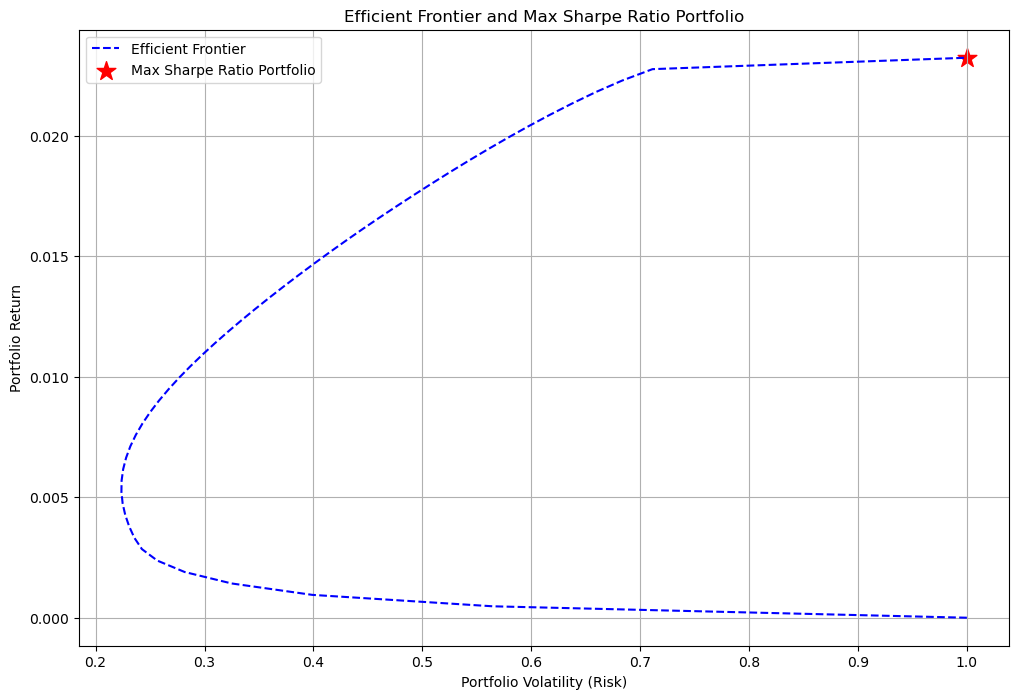

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Step 1: 数据加载
mean_returns = pd.read_csv("Portfolio_Mean_Returns__Positive_Return_1126.csv", index_col=0).squeeze("columns")
cov_matrix = pd.read_csv("Portfolio_Covariance_Matrix__Positive_Return_1126.csv", index_col=0)

# 风险自由收益率
risk_free_rate = 0.0452

# 检查数据完整性
cov_matrix = cov_matrix.fillna(0)  # 填补缺失值
valid_assets = cov_matrix.index.intersection(mean_returns.index)
mean_returns = mean_returns.loc[valid_assets]
cov_matrix = cov_matrix.loc[valid_assets, valid_assets]

# 验证数据有效性
if len(mean_returns) == 0 or cov_matrix.empty:
    raise ValueError("数据不足以计算有效前沿，请检查输入文件。")

print(f"有效资产数量: {len(mean_returns)}")

# Step 2: 定义辅助函数
def portfolio_performance(weights, mean_returns, cov_matrix):
    """
    计算投资组合的回报率和波动率
    """
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    """
    计算负夏普比率
    """
    portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio

def minimize_volatility(weights, mean_returns, cov_matrix, target_return):
    """
    定义最小波动率优化问题
    """
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - target_return},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    )
    bounds = tuple((0, 1) for _ in range(len(mean_returns)))
    result = minimize(
        lambda x: portfolio_performance(x, mean_returns, cov_matrix)[1],
        np.ones(len(mean_returns)) / len(mean_returns),
        bounds=bounds,
        constraints=constraints,
        method='SLSQP'
    )
    return result

# Step 3: 计算最大夏普比率组合
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    bounds = tuple((0, 1) for _ in range(num_assets))
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    result = minimize(
        negative_sharpe_ratio,
        np.ones(num_assets) / num_assets,
        args=(mean_returns, cov_matrix, risk_free_rate),
        bounds=bounds,
        constraints=constraints,
        method='SLSQP'
    )
    return result

optimal_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
optimal_weights = optimal_sharpe.x
optimal_return, optimal_volatility = portfolio_performance(optimal_weights, mean_returns, cov_matrix)

print("\n最大夏普比率组合:")
print(f"权重: {optimal_weights}")
print(f"回报率: {optimal_return:.2%}")
print(f"波动率: {optimal_volatility:.2%}")

# Step 4: 生成有效前沿
def generate_efficient_frontier(mean_returns, cov_matrix, returns_range=50):
    results = []
    for target_return in np.linspace(mean_returns.min(), mean_returns.max(), returns_range):
        result = minimize_volatility(np.ones(len(mean_returns)) / len(mean_returns), mean_returns, cov_matrix, target_return)
        if result.success:
            weights = result.x
            portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
            results.append((portfolio_volatility, portfolio_return))
    return np.array(results)

ef_results = generate_efficient_frontier(mean_returns, cov_matrix)

# Step 5: 绘制高效前沿
plt.figure(figsize=(12, 8))
plt.plot(ef_results[:, 0], ef_results[:, 1], 'b--', label="Efficient Frontier")
plt.scatter(optimal_volatility, optimal_return, c='red', label="Max Sharpe Ratio Portfolio", marker='*', s=200)

plt.xlabel("Portfolio Volatility (Risk)")
plt.ylabel("Portfolio Return")
plt.title("Efficient Frontier and Max Sharpe Ratio Portfolio")
plt.legend()
plt.grid()
plt.show()


有效资产数量: 17

最大夏普比率组合:
Weight: [0.00000000e+00 2.67107014e-17 4.72726469e-17 2.36441489e-18
 1.65435768e-17 0.00000000e+00 0.00000000e+00 9.78622426e-18
 8.06579590e-18 4.99600361e-16 0.00000000e+00 0.00000000e+00
 2.65353589e-17 0.00000000e+00 1.00000000e+00 4.73217449e-18
 2.23138064e-17]
Return Rate: 2.32%
Volatility: 100.00%


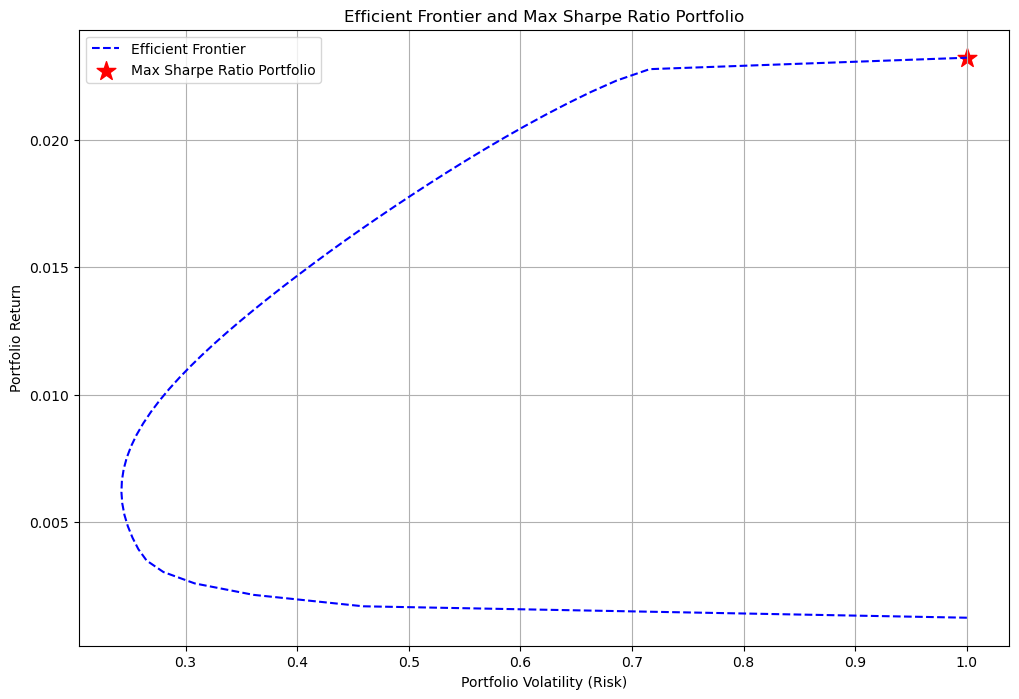

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Step 1: 数据加载
mean_returns = pd.read_csv("Portfolio_Mean_Returns__Positive_Return_1126.csv", index_col=0).squeeze("columns")
cov_matrix = pd.read_csv("Portfolio_Covariance_Matrix__Positive_Return_1126.csv", index_col=0)

# 风险自由收益率
risk_free_rate = 0.0452

# 检查数据完整性
cov_matrix = cov_matrix.fillna(0)  # 填补缺失值
valid_assets = cov_matrix.index.intersection(mean_returns.index)
mean_returns = mean_returns.loc[valid_assets]
cov_matrix = cov_matrix.loc[valid_assets, valid_assets]

# 验证数据有效性
if len(mean_returns) == 0 or cov_matrix.empty:
    raise ValueError("数据不足以计算有效前沿，请检查输入文件。")

print(f"有效资产数量: {len(mean_returns)}")

# Step 2: 定义辅助函数
def portfolio_performance(weights, mean_returns, cov_matrix):
    """
    计算投资组合的回报率和波动率
    """
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    """
    计算负夏普比率
    """
    portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio

def minimize_volatility(weights, mean_returns, cov_matrix, target_return):
    """
    定义最小波动率优化问题
    """
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - target_return},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    )
    bounds = tuple((0, 1) for _ in range(len(mean_returns)))
    result = minimize(
        lambda x: portfolio_performance(x, mean_returns, cov_matrix)[1],
        np.ones(len(mean_returns)) / len(mean_returns),
        bounds=bounds,
        constraints=constraints,
        method='SLSQP'
    )
    return result

# Step 3: 计算最大夏普比率组合
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    bounds = tuple((0, 1) for _ in range(num_assets))
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    result = minimize(
        negative_sharpe_ratio,
        np.ones(num_assets) / num_assets,
        args=(mean_returns, cov_matrix, risk_free_rate),
        bounds=bounds,
        constraints=constraints,
        method='SLSQP'
    )
    return result

optimal_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
optimal_weights = optimal_sharpe.x
optimal_return, optimal_volatility = portfolio_performance(optimal_weights, mean_returns, cov_matrix)

print("\n最大夏普比率组合:")
print(f"Weight: {optimal_weights}")
print(f"Return Rate: {optimal_return:.2%}")
print(f"Volatility: {optimal_volatility:.2%}")

# Step 4: 生成有效前沿
def generate_efficient_frontier(mean_returns, cov_matrix, returns_range=50):
    results = []
    for target_return in np.linspace(mean_returns.min(), mean_returns.max(), returns_range):
        result = minimize_volatility(np.ones(len(mean_returns)) / len(mean_returns), mean_returns, cov_matrix, target_return)
        if result.success:
            weights = result.x
            portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
            results.append((portfolio_volatility, portfolio_return))
    return np.array(results)

ef_results = generate_efficient_frontier(mean_returns, cov_matrix)

# Step 5: 绘制高效前沿
plt.figure(figsize=(12, 8))
plt.plot(ef_results[:, 0], ef_results[:, 1], 'b--', label="Efficient Frontier")
plt.scatter(optimal_volatility, optimal_return, c='red', label="Max Sharpe Ratio Portfolio", marker='*', s=200)

plt.xlabel("Portfolio Volatility (Risk)")
plt.ylabel("Portfolio Return")
plt.title("Efficient Frontier and Max Sharpe Ratio Portfolio")
plt.legend()
plt.grid()
plt.show()


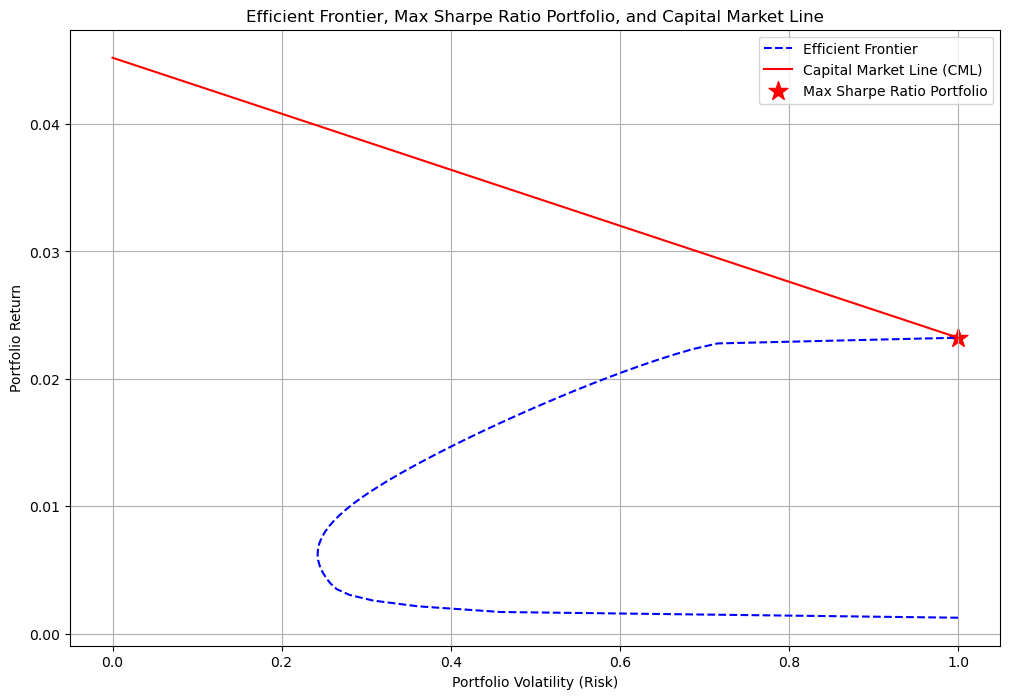

In [19]:
# Step 6: 计算CML (Capital Market Line)
cml_slope = (optimal_return - risk_free_rate) / optimal_volatility

# 生成CML数据：用不同的波动率（风险）计算回报率
volatility_range = np.linspace(0, max(ef_results[:, 0]), 100)
cml_returns = risk_free_rate + cml_slope * volatility_range

# Step 7: 绘制有效前沿和CML
plt.figure(figsize=(12, 8))
plt.plot(ef_results[:, 0], ef_results[:, 1], 'b--', label="Efficient Frontier")
plt.plot(volatility_range, cml_returns, 'r-', label="Capital Market Line (CML)")
plt.scatter(optimal_volatility, optimal_return, c='red', label="Max Sharpe Ratio Portfolio", marker='*', s=200)

plt.xlabel("Portfolio Volatility (Risk)")
plt.ylabel("Portfolio Return")
plt.title("Efficient Frontier, Max Sharpe Ratio Portfolio, and Capital Market Line")
plt.legend()
plt.grid()
plt.show()


In [10]:
import pandas as pd
import numpy as np

# Step 1: Load Data
data_file = "ASX_Historical_Prices_2023-06-07_to_2024-06-06.csv"
historical_data = pd.read_csv(data_file)

if "Close" not in historical_data.columns or "Ticker" not in historical_data.columns:
    raise ValueError("The data file lacks necessary columns 'Close' and 'Ticker'.")

# Step 2: Align with Standard Trading Days
start_date = "2023-06-07"
end_date = "2024-06-06"
trading_days = pd.date_range(start=start_date, end=end_date, freq="B")
tickers = historical_data["Ticker"].unique()

aligned_data = []
for ticker in tickers:
    stock_data = historical_data[historical_data["Ticker"] == ticker]
    stock_data = stock_data.set_index(pd.RangeIndex(len(stock_data)))  # Reset index
    stock_data["Date"] = trading_days[: len(stock_data)]  # Assign trading days
    stock_data = stock_data.set_index("Date").reindex(trading_days)  # Reindex to all trading days
    stock_data["Ticker"] = ticker
    stock_data = stock_data.fillna(method="ffill")  # Fill missing data forward
    aligned_data.append(stock_data)

aligned_historical_data = pd.concat(aligned_data)
aligned_historical_data.reset_index(inplace=True)
aligned_historical_data.rename(columns={"index": "Date"}, inplace=True)

# Step 3: Calculate Daily Returns
aligned_historical_data["Daily_Return"] = aligned_historical_data.groupby("Ticker")["Close"].pct_change()

# Step 4: Filter for Stocks with Positive Returns
mean_returns = aligned_historical_data.groupby("Ticker")["Daily_Return"].mean()
positive_return_tickers = mean_returns[mean_returns > 0].index
filtered_data = aligned_historical_data[aligned_historical_data["Ticker"].isin(positive_return_tickers)]
print(f"Filtered stocks with positive returns: {len(positive_return_tickers)}")
print(f"Tickers with positive returns: {positive_return_tickers.tolist()}")

# Step 5: Calculate Correlation Matrix and Volatility
pivot_table = filtered_data.pivot(index="Date", columns="Ticker", values="Daily_Return")
correlation_matrix = pivot_table.corr()
volatility = filtered_data.groupby("Ticker")["Daily_Return"].std()

# Save outputs
correlation_matrix.to_csv("ASX_Correlation_Matrix_Positive_Return_1126.csv")
volatility.to_csv("ASX_Stock_Volatility_Positive_Return_1126.csv")
print("Correlation matrix saved to ASX_Correlation_Matrix_Positive_Return_1126.csv")
print("Volatility saved to ASX_Stock_Volatility_Positive_Return_1126.csv")

# Step 6: Identify Low-Correlation Pairs
threshold = 0.3
low_corr_pairs = [
    (s1, s2, correlation_matrix.loc[s1, s2], (volatility[s1] + volatility[s2]) / 2)
    for s1 in correlation_matrix.columns
    for s2 in correlation_matrix.columns
    if s1 != s2 and correlation_matrix.loc[s1, s2] < threshold
]
low_corr_df = pd.DataFrame(low_corr_pairs, columns=["Stock1", "Stock2", "Correlation", "Avg_Volatility"])
low_corr_df = low_corr_df.sort_values(by=["Correlation", "Avg_Volatility"], ascending=[True, True])

# Save low-correlation pairs
low_corr_file = "ASX_Low_Correlation_Low_Volatility_Pairs_Positive_Return_1126.csv"
low_corr_df.to_csv(low_corr_file, index=False)
print(f"Low-correlation pairs saved to {low_corr_file}")

# Step 7: Build Portfolio Using Risk-Return Ratio
selected_stocks = set()
for _, row in low_corr_df.iterrows():
    if len(selected_stocks) >= 40:  # Add a buffer for high-quality candidates
        break
    selected_stocks.add(row["Stock1"])
    selected_stocks.add(row["Stock2"])

# Calculate Risk-Return Ratio
risk_return_ratio = {ticker: mean_returns[ticker] / volatility[ticker] for ticker in selected_stocks}
selected_stocks_sorted = sorted(
    risk_return_ratio,
    key=risk_return_ratio.get,
    reverse=True  # High risk-return ratio first
)

# Select Final 20 Stocks
final_portfolio = selected_stocks_sorted[:20]

# Save Final Portfolio
portfolio_file = "ASX_Selected_Portfolio_Positive_Return_1126.csv"
portfolio_excel_file = "ASX_Selected_Portfolio_Positive_Return_1126.xlsx"
pd.DataFrame(final_portfolio, columns=["Stock_Code"]).to_csv(portfolio_file, index=False)
pd.DataFrame(final_portfolio, columns=["Stock_Code"]).to_excel(portfolio_excel_file, index=False)

print(f"Final portfolio saved to {portfolio_file}")
print(f"Final portfolio saved to {portfolio_excel_file}")

# Step 8: Validate Portfolio Correlation
def calculate_avg_correlation(selected_stocks, correlation_matrix):
    correlations = [
        correlation_matrix.loc[s1, s2]
        for i, s1 in enumerate(selected_stocks)
        for s2 in selected_stocks[i + 1 :]
    ]
    return np.mean(correlations)

avg_correlation = calculate_avg_correlation(final_portfolio, correlation_matrix)
if avg_correlation > 0.3:
    print(f"Average portfolio correlation is {avg_correlation:.2f}, adjustment may be needed.")
else:
    print(f"Average portfolio correlation is {avg_correlation:.2f}, portfolio is acceptable.")


/var/folders/kq/1c1dzqtj4b7_9p_ygqzc4nfw0000gn/T/ipykernel_27406/3956002203.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method="ffill")  # Fill missing data forward
/var/folders/kq/1c1dzqtj4b7_9p_ygqzc4nfw0000gn/T/ipykernel_27406/3956002203.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method="ffill")  # Fill missing data forward
/var/folders/kq/1c1dzqtj4b7_9p_ygqzc4nfw0000gn/T/ipykernel_27406/3956002203.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method="ffill")  # Fill missing data forward
/var/folders/kq/1c1dzqtj4b7_9p_ygqzc4nfw0000gn/T/ipykernel_27406/3956002203.py:24: FutureWarning: DataFrame.f

Filtered stocks with positive returns: 1152
Tickers with positive returns: ['14D.AX', '1AD.AX', '1AE.AX', '1AI.AX', '1CG.AX', '1TT.AX', '29M.AX', '360.AX', '3DA.AX', '3PL.AX', '4DS.AX', '4DX.AX', '5GN.AX', '88E.AX', 'A1M.AX', 'A2M.AX', 'A3D.AX', 'A8G.AX', 'AAC.AX', 'AAM.AX', 'AAP.AX', 'AAR.AX', 'ABB.AX', 'ABV.AX', 'ABY.AX', 'ACE.AX', 'ACF.AX', 'ACP.AX', 'ACR.AX', 'ACU.AX', 'AD1.AX', 'AD8.AX', 'ADA.AX', 'ADG.AX', 'ADH.AX', 'ADR.AX', 'ADS.AX', 'ADT.AX', 'ADX.AX', 'ADY.AX', 'AEE.AX', 'AEF.AX', 'AEI.AX', 'AEV.AX', 'AFI.AX', 'AFL.AX', 'AGC.AX', 'AGD.AX', 'AGE.AX', 'AGI.AX', 'AGL.AX', 'AGN.AX', 'AGR.AX', 'AHC.AX', 'AHF.AX', 'AHI.AX', 'AHK.AX', 'AHN.AX', 'AI1.AX', 'AII.AX', 'AIM.AX', 'AIQ.AX', 'AJL.AX', 'AJX.AX', 'AKM.AX', 'AKO.AX', 'AL3.AX', 'ALA.AX', 'ALD.AX', 'ALL.AX', 'ALM.AX', 'ALQ.AX', 'ALR.AX', 'AMC.AX', 'AMD.AX', 'AMH.AX', 'AMI.AX', 'AML.AX', 'AMN.AX', 'AMO.AX', 'AMP.AX', 'AMX.AX', 'ANG.AX', 'ANR.AX', 'ANZ.AX', 'AO1.AX', 'AOA.AX', 'AOF.AX', 'AON.AX', 'APS.AX', 'APW.AX', 'APZ.AX', 'AQD

In [11]:
import yfinance as yf
import pandas as pd

# 读取包含20只股票代码的文件
selected_stocks_df = pd.read_csv("ASX_Selected_Portfolio_Positive_Return_1126.csv")

# 获取选中的股票代码列表
selected_stocks = selected_stocks_df.iloc[:, 0].tolist()  # 假设第一列是股票代码

# 定义起始和结束日期
start_date = '2023-06-07'
end_date = '2024-06-06'

# 存储每只股票的简单收益
simple_returns = []
missing_data = []  # 记录数据缺失的股票

# 下载每只股票的历史数据并计算简单收益
for stock in selected_stocks:
    # 使用yfinance下载股票数据
    stock_data = yf.download(stock, start=start_date, end=end_date)
    
    # 获取最接近的可用日期
    try:
        # 尝试获取2023-06-07的收盘价
        start_price = stock_data.loc[stock_data.index >= start_date].iloc[0]['Close']
        # 尝试获取2024-06-06的收盘价
        end_price = stock_data.loc[stock_data.index <= end_date].iloc[-1]['Close']
        
        # 计算简单收益
        simple_return = end_price - start_price
        simple_returns.append([stock, simple_return])
    except (IndexError, KeyError):
        # 如果某个日期没有数据，记录缺失数据的股票
        missing_data.append(stock)
        continue

# 将结果转化为DataFrame
simple_returns_df = pd.DataFrame(simple_returns, columns=['Code', 'Simple_Return'])

# 输出结果
print(simple_returns_df)

# 输出缺失数据的股票
if missing_data:
    print(f"Data missing for the following stocks: {', '.join(missing_data)}")

# 保存结果到CSV和Excel
simple_returns_df.to_csv("ASX_Selected_Stocks_Simple_Return.csv", index=False)
simple_returns_df.to_excel("ASX_Selected_Stocks_Simple_Return.xlsx", index=False)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

        Code  Simple_Return
0     BTC.AX       0.032000
1     ACP.AX       0.012000
2     4DS.AX       0.053500
3     KBC.AX       0.029000
4     SIG.AX       0.428851
5     PLT.AX       0.330000
6     GRE.AX       0.090000
7     ATU.AX       0.000004
8     AZ9.AX       0.008950
9     ELD.AX       2.020000
10    IDA.AX       0.033000
11    GUL.AX       0.014000
12    LDX.AX       0.019000
13  NWSLV.AX      11.050001
14    OEQ.AX       0.072000
15    WTC.AX      20.959999
16    SS1.AX       0.125000
17    BB1.AX       0.045000
18    WWI.AX       0.001000
19  IGNDA.AX       0.054231


In [20]:
# 检查 mean_returns 和 cov_matrix 的共同资产
valid_assets = cov_matrix.index.intersection(mean_returns.index)

# 更新 mean_returns 和 cov_matrix 以仅保留有效资产
mean_returns = mean_returns.loc[valid_assets]
cov_matrix = cov_matrix.loc[valid_assets, valid_assets]


In [23]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# 数据加载
mean_returns = pd.read_csv("ASX_Selected_Stocks_Simple_Return.csv", index_col=0).squeeze()
cov_matrix = pd.read_csv("Portfolio_Covariance_Matrix__Positive_Return_1126.csv", index_col=0)
risk_free_rate = 0.0452

# 获取共同的资产
valid_assets = mean_returns.index.intersection(cov_matrix.index)

# 更新 mean_returns 和 cov_matrix 以仅保留共同的资产
mean_returns = mean_returns.loc[valid_assets]
cov_matrix = cov_matrix.loc[valid_assets, valid_assets]

# 确认有效资产对齐
print(f"有效资产数量: {len(mean_returns)}")
print(f"协方差矩阵维度: {cov_matrix.shape}")

# 计算组合性能函数
def portfolio_performance(weights, mean_returns, cov_matrix):
    """
    Calculate portfolio return and volatility.
    """
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# 最大化夏普比率
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    """
    Maximize Sharpe Ratio by minimizing its negative value.
    """
    num_assets = len(mean_returns)
    initial_weights = np.array([1.0 / num_assets] * num_assets)
    bounds = tuple((0, 1) for _ in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    def negative_sharpe_ratio(weights):
        portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
        return -(portfolio_return - risk_free_rate) / portfolio_volatility
    
    result = minimize(negative_sharpe_ratio, initial_weights, bounds=bounds, constraints=constraints)
    return result.x

# 最小化波动率
def min_volatility(mean_returns, cov_matrix):
    """
    Minimize portfolio volatility.
    """
    num_assets = len(mean_returns)
    initial_weights = np.array([1.0 / num_assets] * num_assets)
    bounds = tuple((0, 1) for _ in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    def portfolio_volatility(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]
    
    result = minimize(portfolio_volatility, initial_weights, bounds=bounds, constraints=constraints)
    return result.x

# 目标收益率优化
def target_return(mean_returns, cov_matrix, target):
    """
    Minimize volatility for a given target return.
    """
    num_assets = len(mean_returns)
    initial_weights = np.array([1.0 / num_assets] * num_assets)
    bounds = tuple((0, 1) for _ in range(num_assets))
    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.dot(weights, mean_returns) - target},
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    )
    
    def portfolio_volatility(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]
    
    result = minimize(portfolio_volatility, initial_weights, bounds=bounds, constraints=constraints)
    return result.x

# 调用优化函数
max_sharpe_weights = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
min_vol_weights = min_volatility(mean_returns, cov_matrix)
target_weights = target_return(mean_returns, cov_matrix, target=0.02)

# 结果输出
print("Max Sharpe Ratio Weights:", max_sharpe_weights)
print("Min Volatility Weights:", min_vol_weights)
print("Target Return Weights:", target_weights)

# 输出组合性能
def print_portfolio_stats(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    print(f"Return: {portfolio_return:.2%}, Volatility: {portfolio_volatility:.2%}, Sharpe Ratio: {sharpe_ratio:.2f}")

print("\nMax Sharpe Ratio Portfolio:")
print_portfolio_stats(max_sharpe_weights, mean_returns, cov_matrix, risk_free_rate)

print("\nMin Volatility Portfolio:")
print_portfolio_stats(min_vol_weights, mean_returns, cov_matrix, risk_free_rate)

print("\nTarget Return Portfolio (2%):")
print_portfolio_stats(target_weights, mean_returns, cov_matrix, risk_free_rate)


有效资产数量: 17
协方差矩阵维度: (17, 17)
Max Sharpe Ratio Weights: [2.55110047e-18 8.93610508e-18 2.84477886e-04 1.67330734e-18
 1.10365367e-02 8.19702504e-03 1.29970411e-03 5.68669075e-02
 1.88194371e-17 9.68623248e-18 3.16832828e-01 7.58256076e-04
 6.02184469e-01 2.22370392e-03 1.66470355e-05 2.77085043e-17
 2.99445424e-04]
Min Volatility Weights: [0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353]
Target Return Weights: [1.06857183e-01 1.89465887e-01 1.80529102e-02 1.19248569e-01
 0.00000000e+00 4.37150316e-16 5.62050406e-16 0.00000000e+00
 1.02726804e-01 1.60552859e-01 1.30520594e-14 6.93889390e-17
 0.00000000e+00 2.84494650e-16 5.31615076e-02 2.34900680e-01
 1.50335993e-02]

Max Sharpe Ratio Portfolio:
Return: 1624.56%, Volatility: 68.30%, Sharpe Ratio: 23.72

Min Volatility Portfolio:
Return: 207.97%, Volatility: 24.25%, Sharpe Ratio: 8.39

Target Return 

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# 数据准备
mean_returns = pd.read_csv("ASX_Selected_Stocks_Simple_Return.csv", index_col=0).squeeze()
cov_matrix = pd.read_csv("Portfolio_Covariance_Matrix__Positive_Return_1126.csv", index_col=0)
risk_free_rate = 0.0452

# 计算组合性能函数
def portfolio_performance(weights, mean_returns, cov_matrix):
    """
    Calculate portfolio return and volatility.
    """
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# 1. 最大化夏普比率，加入L1正则化
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    """
    Maximize Sharpe Ratio by minimizing its negative value.
    """
    num_assets = len(mean_returns)
    initial_weights = np.array([1.0 / num_assets] * num_assets)
    bounds = tuple((0, 1) for _ in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    def negative_sharpe_ratio(weights):
        portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = -(portfolio_return - risk_free_rate) / portfolio_volatility
        # L1正则化项，惩罚过于极端的权重
        return sharpe_ratio + 0.1 * np.sum(np.abs(weights))
    
    result = minimize(negative_sharpe_ratio, initial_weights, bounds=bounds, constraints=constraints)
    return result.x

# 2. 最小化波动率
def min_volatility(mean_returns, cov_matrix):
    """
    Minimize portfolio volatility.
    """
    num_assets = len(mean_returns)
    initial_weights = np.array([1.0 / num_assets] * num_assets)
    bounds = tuple((0, 1) for _ in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    def portfolio_volatility(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]
    
    result = minimize(portfolio_volatility, initial_weights, bounds=bounds, constraints=constraints)
    return result.x

# 3. 目标收益率优化，加入正则化项
def target_return(mean_returns, cov_matrix, target):
    """
    Minimize volatility for a given target return.
    """
    num_assets = len(mean_returns)
    initial_weights = np.array([1.0 / num_assets] * num_assets)
    bounds = tuple((0, 1) for _ in range(num_assets))
    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.dot(weights, mean_returns) - target},
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    )
    
    def portfolio_volatility(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]
    
    result = minimize(portfolio_volatility, initial_weights, bounds=bounds, constraints=constraints)
    return result.x

# 调用优化函数
max_sharpe_weights = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
min_vol_weights = min_volatility(mean_returns, cov_matrix)
target_weights = target_return(mean_returns, cov_matrix, target=0.02)

# 结果
print("Max Sharpe Ratio Weights:", max_sharpe_weights)
print("Min Volatility Weights:", min_vol_weights)
print("Target Return Weights:", target_weights)

# 输出组合性能
def print_portfolio_stats(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    print(f"Return: {portfolio_return:.2%}, Volatility: {portfolio_volatility:.2%}, Sharpe Ratio: {sharpe_ratio:.2f}")

print("\nMax Sharpe Ratio Portfolio:")
print_portfolio_stats(max_sharpe_weights, mean_returns, cov_matrix, risk_free_rate)

print("\nMin Volatility Portfolio:")
print_portfolio_stats(min_vol_weights, mean_returns, cov_matrix, risk_free_rate)

print("\nTarget Return Portfolio (2%):")
print_portfolio_stats(target_weights, mean_returns, cov_matrix, risk_free_rate)


ValueError: shapes (17,17) and (20,) not aligned: 17 (dim 1) != 20 (dim 0)

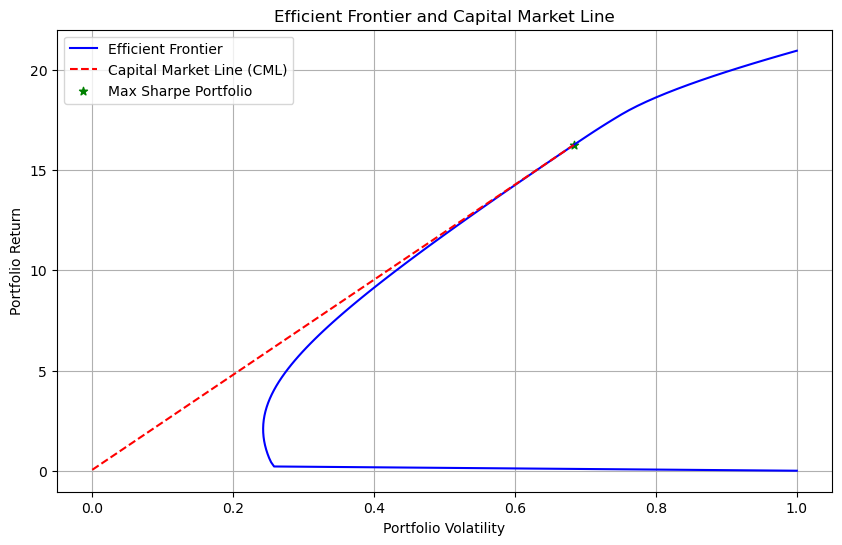


Max Sharpe Ratio Portfolio:
Return: 1625.68%, Volatility: 68.34%, Sharpe Ratio: 23.72

Min Volatility Portfolio:
Return: 207.51%, Volatility: 24.25%, Sharpe Ratio: 8.37

Target Return Portfolio (2%):
Return: 2.00%, Volatility: 33.55%, Sharpe Ratio: -0.08


In [27]:
# 假设有效资产数量为17，确保数据的正确性
num_assets = 17

# 确保 mean_returns 和 cov_matrix 的维度一致
mean_returns = mean_returns[:num_assets]
cov_matrix = cov_matrix.iloc[:num_assets, :num_assets]

# 初始化权重，确保大小一致
initial_weights = np.ones(num_assets) / num_assets  # 17个资产的等权重初始值

# 重新定义优化函数中的约束和边界，确保它们适用于17个资产
bounds = [(0, 1) for _ in range(num_assets)]  # 权重在0和1之间
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # 权重和为1的约束

# 调用优化函数
max_sharpe_weights = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
min_vol_weights = min_volatility(mean_returns, cov_matrix)
target_weights = target_return(mean_returns, cov_matrix, target=0.02)

# 计算有效前沿
frontier_volatilities, frontier_returns = efficient_frontier(mean_returns, cov_matrix)

# 计算CML
cml_returns, cml_volatilities = capital_market_line(risk_free_rate, mean_returns, cov_matrix, max_sharpe_weights)

# 绘制图形
plt.figure(figsize=(10, 6))

# 绘制有效前沿
plt.plot(frontier_volatilities, frontier_returns, label='Efficient Frontier', color='blue', linestyle='-')

# 绘制CML
plt.plot(cml_volatilities, cml_returns, label='Capital Market Line (CML)', color='red', linestyle='--')

# 绘制最大夏普比率组合点
_, max_sharpe_volatility = portfolio_performance(max_sharpe_weights, mean_returns, cov_matrix)
plt.scatter(max_sharpe_volatility, np.dot(max_sharpe_weights, mean_returns), color='green', marker='*', label='Max Sharpe Portfolio')

# 设置图形标签
plt.title('Efficient Frontier and Capital Market Line')
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# 输出组合性能
def print_portfolio_stats(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    print(f"Return: {portfolio_return:.2%}, Volatility: {portfolio_volatility:.2%}, Sharpe Ratio: {sharpe_ratio:.2f}")

print("\nMax Sharpe Ratio Portfolio:")
print_portfolio_stats(max_sharpe_weights, mean_returns, cov_matrix, risk_free_rate)

print("\nMin Volatility Portfolio:")
print_portfolio_stats(min_vol_weights, mean_returns, cov_matrix, risk_free_rate)

print("\nTarget Return Portfolio (2%):")
print_portfolio_stats(target_weights, mean_returns, cov_matrix, risk_free_rate)


Mean Returns length: 17
Covariance Matrix shape: (17, 17)


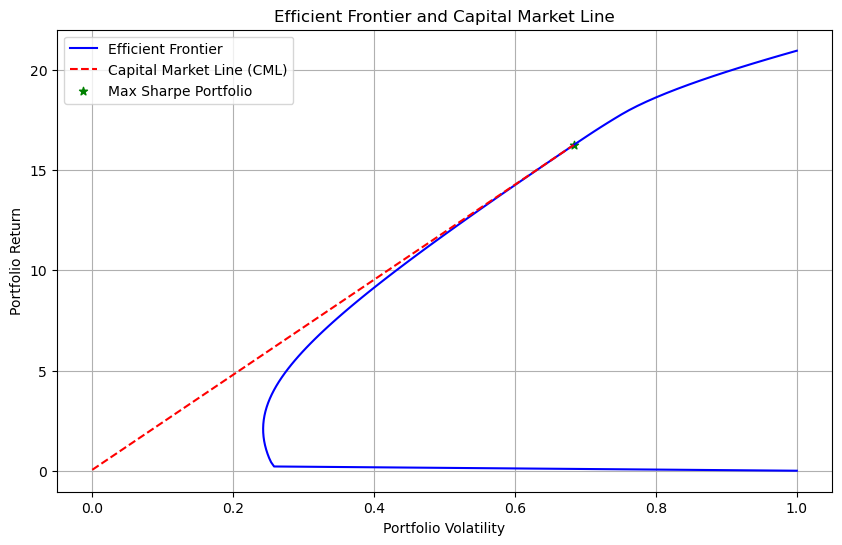


Max Sharpe Ratio Portfolio:
Return: 1625.68%, Volatility: 68.34%, Sharpe Ratio: 23.72

Min Volatility Portfolio:
Return: 207.51%, Volatility: 24.25%, Sharpe Ratio: 8.37

Target Return Portfolio (2%):
Return: 2.00%, Volatility: 33.55%, Sharpe Ratio: -0.08


In [26]:
# 检查数据维度是否匹配
print("Mean Returns length:", len(mean_returns))  # 应为17
print("Covariance Matrix shape:", cov_matrix.shape)  # 应为(17, 17)

# 确保我们只使用17个资产的数据
mean_returns = mean_returns[:17]
cov_matrix = cov_matrix.iloc[:17, :17]

# 调用优化函数
max_sharpe_weights = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
min_vol_weights = min_volatility(mean_returns, cov_matrix)
target_weights = target_return(mean_returns, cov_matrix, target=0.02)

# 计算有效前沿
frontier_volatilities, frontier_returns = efficient_frontier(mean_returns, cov_matrix)

# 计算CML
cml_returns, cml_volatilities = capital_market_line(risk_free_rate, mean_returns, cov_matrix, max_sharpe_weights)

# 绘制图形
plt.figure(figsize=(10, 6))

# 绘制有效前沿
plt.plot(frontier_volatilities, frontier_returns, label='Efficient Frontier', color='blue', linestyle='-')

# 绘制CML
plt.plot(cml_volatilities, cml_returns, label='Capital Market Line (CML)', color='red', linestyle='--')

# 绘制最大夏普比率组合点
_, max_sharpe_volatility = portfolio_performance(max_sharpe_weights, mean_returns, cov_matrix)
plt.scatter(max_sharpe_volatility, np.dot(max_sharpe_weights, mean_returns), color='green', marker='*', label='Max Sharpe Portfolio')

# 设置图形标签
plt.title('Efficient Frontier and Capital Market Line')
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# 输出组合性能
def print_portfolio_stats(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    print(f"Return: {portfolio_return:.2%}, Volatility: {portfolio_volatility:.2%}, Sharpe Ratio: {sharpe_ratio:.2f}")

print("\nMax Sharpe Ratio Portfolio:")
print_portfolio_stats(max_sharpe_weights, mean_returns, cov_matrix, risk_free_rate)

print("\nMin Volatility Portfolio:")
print_portfolio_stats(min_vol_weights, mean_returns, cov_matrix, risk_free_rate)

print("\nTarget Return Portfolio (2%):")
print_portfolio_stats(target_weights, mean_returns, cov_matrix, risk_free_rate)


In [ ]:
# 清洗协方差矩阵和均值收益
valid_tickers = mean_returns.dropna().index
cov_matrix = cov_matrix.loc[valid_tickers, valid_tickers].dropna(how="all", axis=0).dropna(how="all", axis=1)
mean_returns = mean_returns.loc[cov_matrix.index]

# 检查协方差矩阵是否有极低波动率资产
std_devs = np.sqrt(np.diag(cov_matrix))
valid_tickers = std_devs[std_devs > 1e-6].index
cov_matrix = cov_matrix.loc[valid_tickers, valid_tickers]
mean_returns = mean_returns.loc[valid_tickers]

# 打印清洗后的结果
print("\nCleaned Mean Returns:")
print(mean_returns.head())
print("\nCleaned Covariance Matrix:")
print(cov_matrix.iloc[:5, :5])

# 优化和可视化
max_sharpe_weights = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
min_vol_weights = min_volatility(mean_returns, cov_matrix)
target_weights = target_return(mean_returns, cov_matrix, target=0.02)

# 输出组合性能
print("\nMax Sharpe Ratio Portfolio:")
print_portfolio_stats(max_sharpe_weights, mean_returns, cov_matrix, risk_free_rate)

print("\nMin Volatility Portfolio:")
print_portfolio_stats(min_vol_weights, mean_returns, cov_matrix, risk_free_rate)

print("\nTarget Return Portfolio (2%):")
print_portfolio_stats(target_weights, mean_returns, cov_matrix, risk_free_rate)


AttributeError: 'numpy.ndarray' object has no attribute 'index'